In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import open3d as o3d
import os
import matplotlib.pyplot as plt
import yaml
from concurrent.futures import ProcessPoolExecutor

import wire_detection_utils as wdu
import viz_utils as vu

In [7]:
with open('wire_detect_config.yaml', 'r') as file:
    detection_config = yaml.safe_load(file)

# Create a WireDetector instance
wire_detector = wdu.WireDetector(detection_config)
input_image_size = [480, 270]

# folder = '/media/tyler/Storage/Research/Datasets/wire_tracking_05-07_40fov/'
# folder = '/media/tyler/Storage/field_tests/street_wire_experiments/wire_tracking_05-07_40fov/'
folder = '/home/tyler/Documents/wire_tracking_05-07_40fov/'
target_timestamp = 1746650644465219840 # straight wire
# target_timestamp = 1746650656862302432 # angled wire

# folder = '/media/tyler/Storage/field_tests/acfa_3-21/'
# target_timestamp = 1742581588251564064

# folder = '/media/tyler/Storage/field_tests/hawkins_2-19/wire_tracking_02-19_1/'
# target_timestamp = 1739975958352738816 # seperated wires
# target_timestamp = 1739975963786320032 # wires in a bundle
# target_timestamp = 1739975992503588928  # wires clean

rgb_folder = folder + 'rgb_images/'
depth_folder = folder + 'depth_images/'
camera_intrinsics_file = folder + 'rgb_camera_intrinsics.npy'
camera_intrinsics = np.load(camera_intrinsics_file)

closest_rgb_timestamp = None
closest_depth_timestamp = None
for image_name in os.listdir(rgb_folder):
    if image_name.endswith('.png'):
        timestamp = int(image_name.split('.')[0])
        if closest_rgb_timestamp is None or abs(timestamp - target_timestamp) < abs(closest_rgb_timestamp - target_timestamp):
            closest_rgb_timestamp = timestamp
            closest_rgb_timestamp_s = timestamp * 1e-9  # Convert to seconds
for image_name in os.listdir(depth_folder):
    if image_name.endswith('.npy'):
        timestamp = int(image_name.split('.')[0])
        if closest_depth_timestamp is None or abs(timestamp - target_timestamp) < abs(closest_depth_timestamp - target_timestamp):
            closest_depth_timestamp = timestamp
            closest_depth_timestamp_s = timestamp * 1e-9  # Convert to seconds

rgb_image_path = str(closest_rgb_timestamp) + '.png'
depth_image_path = str(closest_depth_timestamp) + '.npy'

print(f"Time difference between closest RGB and depth images: {abs(closest_rgb_timestamp_s - closest_depth_timestamp_s)}")
    
img = cv2.imread(rgb_folder + rgb_image_path)
depth = np.load(depth_folder + depth_image_path)
assert img is not None, "Image not found"
assert depth is not None, "Depth image not found"

Time difference between closest RGB and depth images: 0.07021069526672363


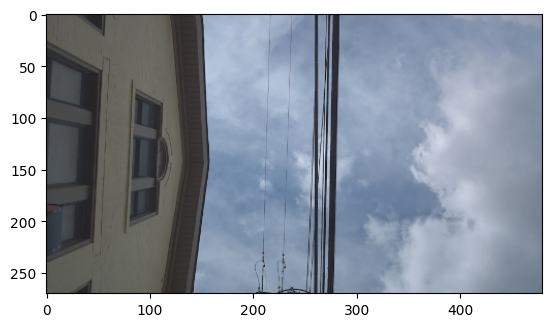

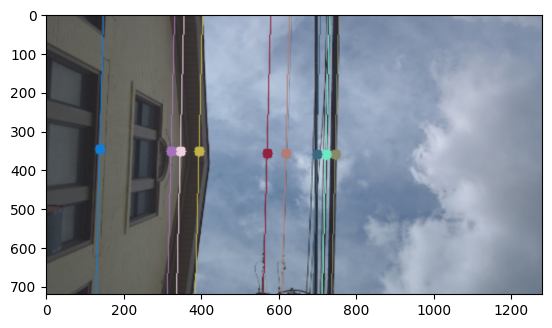

In [8]:
img = cv2.resize(img, (input_image_size[0], input_image_size[1]))
depth = cv2.resize(depth, (input_image_size[0], input_image_size[1]))
cv2.imwrite('detect_3d_output/reference.jpg', img)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Create segmentation mask
wire_lines, wire_midpoints, avg_angle, midpoint_dists_wrt_center = wire_detector.detect_wires_2d(img)

img_2d_detect = img.copy()
rand_colors = np.random.randint(0, 256, (len(wire_midpoints), 3)).tolist()
for i, (x0,y0,x1,y1) in enumerate(wire_lines):
    cv2.line(img_2d_detect, (x0,y0), (x1,y1), tuple(rand_colors[i]), 1)

for i, (x0,y0) in enumerate(wire_midpoints):
    cv2.circle(img_2d_detect, (int(x0), int(y0)), 5, tuple(rand_colors[i]), -1)
img_2d_detect = cv2.resize(img_2d_detect, (1280, 720))
cv2.imwrite('detect_3d_output/wire2d_detect.jpg', img_2d_detect)
plt.figure()
plt.imshow(cv2.cvtColor(img_2d_detect, cv2.COLOR_BGR2RGB))

# create value mask
# lower_black = np.array([0, 0, 0])
# cuttoff = 125
# upper_black = np.array([cuttoff, cuttoff, cuttoff])
# v_mask = cv2.inRange(img, lower_black, upper_black)
# plt.figure()
# plt.imshow(v_mask, cmap='gray')

Regions of interest: [(np.float64(-53.47833896907045), np.float64(-20.47833896907045)), (np.float64(11.52166103092955), np.float64(44.52166103092955))]
ROI line counts: [3, 1]
Time taken for depth gradient calculation: 0.006896 seconds, 145.01 Hz


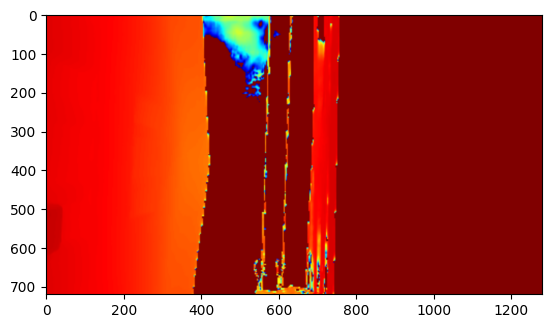

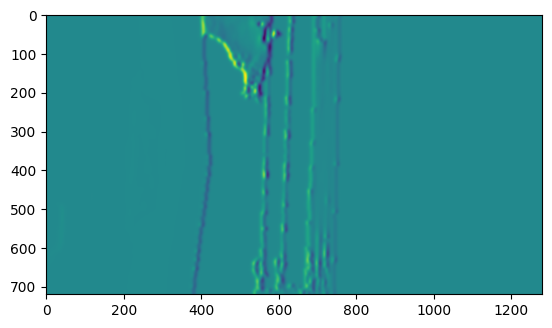

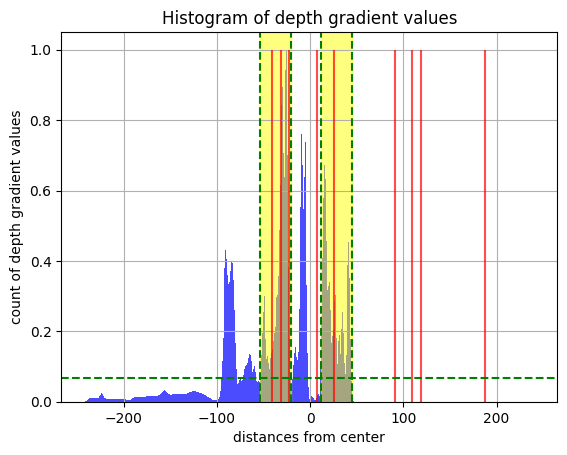

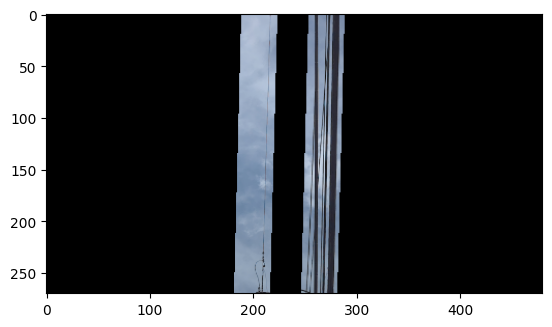

In [9]:
min_depth = 0.5
depth[depth <= min_depth] = 0

depth_viz = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
depth_viz = cv2.applyColorMap(depth_viz, cv2.COLORMAP_JET)
depth_viz = cv2.resize(depth_viz, (1280, 720))
cv2.imwrite('detect_3d_output/depth_viz.jpg', depth_viz)
plt.figure()
plt.imshow(depth_viz)

start_time = time.perf_counter()
depth_gradient_x = cv2.Sobel(depth, cv2.CV_64F, 1, 0, ksize=11)
depth_gradient_y = cv2.Sobel(depth, cv2.CV_64F, 0, 1, ksize=11)
perp_angle = wdu.perpendicular_angle_rad(avg_angle)
depth_gradient = depth_gradient_x * np.cos(perp_angle) + depth_gradient_y * np.sin(perp_angle)

distance, depth_gradient_1d = wdu.project_image_to_axis(depth_gradient, perp_angle)
depth_gradient_1d = np.abs(depth_gradient_1d)
depth_gradient_1d = depth_gradient_1d / np.max(depth_gradient_1d)

dist_hist, bin_edges = np.histogram(distance, bins=np.arange(np.min(distance), np.max(distance), 1), weights=depth_gradient_1d)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
dist_hist = dist_hist / np.max(dist_hist)

threshold = wire_detector.grad_bin_avg_threshold_multiplier * np.mean(dist_hist)
mask = dist_hist > threshold
mask_diff = np.diff(mask.astype(int))
mask_diff = np.concatenate(([0], mask_diff))

start_indices = np.where(mask_diff == 1)[0]
end_indices = np.where(mask_diff == -1)[0]
# if ensure that the first start index is not after the first end index
if start_indices[0] > end_indices[0]:
    start_indices = np.insert(start_indices, 0, 0)
if len(start_indices) > len(end_indices):
    end_indices = np.append(end_indices, len(mask) - 1)
if len(end_indices) > len(start_indices):
    start_indices = np.append(0, start_indices)
assert len(start_indices) == len(end_indices), "Mismatch in start and end indices length"

regions_of_interest = []
roi_line_count = []

for start, end in zip(start_indices, end_indices):
    if bin_centers[start] < bin_centers[end]:
        start = bin_centers[start]
        end = bin_centers[end]
        should_add_region = False
        line_count = 0
        for wire_dist in midpoint_dists_wrt_center: 
            if start <= wire_dist <= end:
                # Append the region to the list
                line_count += 1
                should_add_region = True
                
        if should_add_region:
            regions_of_interest.append((start, end))
            roi_line_count.append(line_count)

print(f"Regions of interest: {regions_of_interest}")
print(f"ROI line counts: {roi_line_count}")

roi_depths, depth_masked, roi_rgbs, rgb_masked = wire_detector.roi_to_point_clouds(regions_of_interest, avg_angle, depth, img)

end_time = time.perf_counter()
print(f"Time taken for depth gradient calculation: {end_time - start_time:.6f} seconds, { 1 / (end_time - start_time):.2f} Hz")

depth_gradient_viz = cv2.normalize(depth_gradient, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
depth_gradient_viz = cv2.resize(depth_gradient_viz, (1280, 720))
cv2.imwrite('detect_3d_output/depth_gradient.jpg', depth_gradient_viz)
plt.figure()
plt.imshow(depth_gradient_viz)

plt.figure()
plt.bar(bin_centers, dist_hist, width=1, color='blue', alpha=0.7)
plt.vlines(midpoint_dists_wrt_center, min(dist_hist), max(dist_hist), color='red', alpha=0.7, label='wire midpoints')
for start, end in regions_of_interest:
    plt.axvspan(start, end, color='yellow', alpha=0.5, label='ROI')
    plt.axvline(x=start, color='green', linestyle='--')
    plt.axvline(x=end, color='green', linestyle='--')
plt.axhline(y=threshold, color='green', linestyle='--', label='ROI mask')
plt.title('Histogram of depth gradient values')
plt.xlabel('distances from center')
plt.ylabel('count of depth gradient values')
plt.grid()
plt.savefig('detect_3d_output/histogram_neg.png')
plt.show()

cv2.imwrite('detect_3d_output/rgb_masked.jpg', rgb_masked)
plt.figure()
plt.imshow(cv2.cvtColor(rgb_masked, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
#run ransac line fitting on sections of the point cloud
start_time = time.perf_counter()
fitted_lines = []
roi_pcs = []
roi_point_colors = []
print(f"Average angle (degrees): {np.degrees(avg_angle)}")
for roi_depth, roi_rgb, line_count in zip(roi_depths, roi_rgbs, roi_line_count):
    # convert depth image to point cloud
    points, colors = wdu.depth_to_pointcloud(roi_depth, camera_intrinsics, roi_rgb, depth_clip=[0.5, 15.0])
    roi_pcs.append(points)
    colors = (np.array(colors) / 255.0)[:,::-1]
    roi_point_colors.append(colors)
    lines = wdu.ransac_line_fitting(points, avg_angle, num_lines=line_count, num_iterations=300, inlier_threshold=0.1016, vert_angle_thresh=0.0398132, horiz_angle_thresh=0.0698132)
    fitted_lines += lines
end_time = time.perf_counter()
assert len(fitted_lines) == sum(roi_line_count), f"Mismatch in fitted lines count: {len(fitted_lines)} vs {sum(roi_line_count)}"

line_heights = []
for line in fitted_lines:
    avg_line_height = np.mean([point[2] for point in line])
    line_heights.append(avg_line_height)
print(f"Line heights: {line_heights}")
print(f"Time taken for RANSAC line fitting: {end_time - start_time:.2f} seconds, {1 / (end_time - start_time):.2f} Hz")

Average angle (degrees): 91.28996990920066
Line heights: [np.float64(8.522921085357666), np.float64(10.585742473602295), np.float64(8.47874402999878), np.float64(3.648094058036804)]
Time taken for RANSAC line fitting: 0.04 seconds, 22.59 Hz


In [11]:
# visualize the fitted lines
vu.visualize_fitted_lines(
    fitted_lines,
    roi_pcs,
    roi_point_colors,
)
    

In [12]:
# visualize point cloud from depth image
depth_image = np.load(depth_folder + depth_image_path)
rgb_img = cv2.imread(rgb_folder + rgb_image_path)
camera_intrinsics = np.load(camera_intrinsics_file)

# vu.visualize_colored_point_cloud(depth_image, rgb_img, camera_intrinsics)
